In [ ]:
import os
import mgclient
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv
from torch_geometric.transforms import ToUndirected
from torch_geometric.utils import negative_sampling
from sentence_transformers import SentenceTransformer

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 120)

In [5]:
MEMGRAPH_HOST = "127.0.0.1"
MEMGRAPH_PORT = 7688
EMBEDDING_MODEL = 'all-MiniLM-L6-v2'

In [27]:
def fetch_and_prepare_data():
    """
    MODIFIED: Fetches data for all specified node types, creates text embeddings, 
    builds the full heterogeneous graph, and derives user-to-user edges for training.
    """
    print("Connecting to Memgraph...")
    conn = mgclient.connect(host=MEMGRAPH_HOST, port=MEMGRAPH_PORT)
    cursor = conn.cursor()
    embed_model = SentenceTransformer(EMBEDDING_MODEL)
    embedding_dim = embed_model.get_sentence_embedding_dimension()
    print(f"Embedding model loaded. Dimension: {embedding_dim}")

    print("Step 1/4: Fetching all relevant nodes...")
    query_nodes = """
    MATCH (n) WHERE n:User OR n:Skill OR n:Strength OR n:Idea OR n:UserPost OR n:Subscription OR n:DailyActivity OR n:StrengthCategory
    RETURN id(n) AS memgraph_id, labels(n)[0] AS label, n.id AS original_id,
           CASE labels(n)[0] WHEN 'User' THEN '' ELSE COALESCE(n.name, n.content, n.title) END AS text
    """
    cursor.execute(query_nodes)
    nodes_df = pd.DataFrame(cursor.fetchall(), columns=["memgraph_id", "label", "original_id", "text"])
    nodes_df['new_id'] = nodes_df.groupby('label').cumcount()
    
    graph_data = HeteroData()
    for label, group in nodes_df.groupby('label'):
        if label == 'User':
            graph_data[label].x = torch.zeros((len(group), embedding_dim), dtype=torch.float)
        else:
            texts = group['text'].fillna('').tolist()
            if texts:
                embeddings = embed_model.encode(texts, show_progress_bar=True, batch_size=128)
                graph_data[label].x = torch.tensor(embeddings, dtype=torch.float)
            else:
                graph_data[label].x = torch.zeros((len(group), embedding_dim), dtype=torch.float)
        graph_data[label].original_id_map = torch.tensor(group['original_id'].values, dtype=torch.long)
        graph_data[label].new_id_map = torch.tensor(group['new_id'].values, dtype=torch.long)

    # Step 2: Build initial user features from their content interactions
    print("Step 2/4: Building initial user features from content interactions...")
    query_user_content_edges = """
    MATCH (u:User)-[r]->(c) WHERE type(r) IN ['HAS_SKILL', 'HAS_STRENGTH', 'SUBMITTED', 'VOTED_ON', 'CREATED', 'HAS_SUBSCRIPTION', 'ENROLLED_IN']
    RETURN u.id AS source_id, labels(c)[0] AS target_label, c.id AS target_id
    """
    cursor.execute(query_user_content_edges)
    user_content_df = pd.DataFrame(cursor.fetchall(), columns=["source_id", "target_label", "target_id"])

    user_features = graph_data['User'].x
    if not user_content_df.empty:
        # This aggregation logic remains the same
        for _, row in user_content_df.iterrows():
            try:
                user_pyg_id = graph_data['User'].new_id_map[graph_data['User'].original_id_map == row['source_id']].item()
                content_label = row['target_label']
                if content_label in graph_data.node_types:
                    content_pyg_id = graph_data[content_label].new_id_map[graph_data[content_label].original_id_map == row['target_id']].item()
                    user_features[user_pyg_id] += graph_data[content_label].x[content_pyg_id]
            except (IndexError, ValueError, KeyError):
                continue
    
    user_original_id_to_pos = {oid.item(): pos for pos, oid in enumerate(graph_data['User'].original_id_map)}
    source_positions = [user_original_id_to_pos.get(sid) for sid in user_content_df['source_id'] if sid in user_original_id_to_pos]
    if source_positions:
        source_pyg_ids_for_degree = graph_data['User'].new_id_map[source_positions]
        user_degrees = torch.bincount(source_pyg_ids_for_degree, minlength=graph_data['User'].num_nodes).float()
        graph_data['User'].x = user_features / user_degrees.unsqueeze(1).clamp(min=1)

    # NEW Step 3: Fetch ALL edges to build the full graph structure for the GNN
    print("Step 3/4: Fetching all edges to build graph structure...")
    query_all_edges = """
    MATCH (source)-[r]->(target)
    RETURN labels(source)[0] AS source_label, source.id AS source_id,
           type(r) AS rel_type,
           labels(target)[0] AS target_label, target.id AS target_id
    """
    cursor.execute(query_all_edges)
    all_edges_df = pd.DataFrame(cursor.fetchall(), columns=["source_label", "source_id", "rel_type", "target_label", "target_id"])

    # Populate edge indices for all relationship types
    for (source_label, rel_type, target_label), group in all_edges_df.groupby(['source_label', 'rel_type', 'target_label']):
        if source_label not in graph_data.node_types or target_label not in graph_data.node_types:
            continue
        
        source_map = {oid.item(): i for i, oid in enumerate(graph_data[source_label].original_id_map)}
        target_map = {oid.item(): i for i, oid in enumerate(graph_data[target_label].original_id_map)}
        
        source_pos = [source_map.get(oid) for oid in group['source_id']]
        target_pos = [target_map.get(oid) for oid in group['target_id']]
        
        valid_indices = [(s, t) for s, t in zip(source_pos, target_pos) if s is not None and t is not None]
        if not valid_indices:
            continue
        
        source_pyg_ids = graph_data[source_label].new_id_map[[s for s, t in valid_indices]]
        target_pyg_ids = graph_data[target_label].new_id_map[[t for s, t in valid_indices]]

        edge_index = torch.stack([source_pyg_ids, target_pyg_ids], dim=0)
        graph_data[source_label, rel_type, target_label].edge_index = edge_index


    # Step 4: Create explicit user-to-user edges for training the link predictor
    print("Step 4/4: Deriving user-to-user connections for training...")
    query_user_user_edges = """
    MATCH (u1:User)-[r1]->(c)<-[r2]-(u2:User)
    WHERE (type(r1) = 'HAS_SKILL' AND type(r2) = 'HAS_SKILL') 
       OR (type(r1) = 'VOTED_ON' AND type(r2) = 'VOTED_ON')
       OR (type(r1) = 'HAS_STRENGTH' AND type(r2) = 'HAS_STRENGTH')
    AND id(u1) < id(u2)
    RETURN u1.id AS source_id, u2.id AS target_id
    """
    cursor.execute(query_user_user_edges)
    user_user_df = pd.DataFrame(cursor.fetchall(), columns=["source_id", "target_id"])
    conn.close()

    if not user_user_df.empty:
        valid_source_mask = user_user_df['source_id'].isin(graph_data['User'].original_id_map.numpy())
        valid_target_mask = user_user_df['target_id'].isin(graph_data['User'].original_id_map.numpy())
        user_user_df = user_user_df[valid_source_mask & valid_target_mask]
        
        if not user_user_df.empty:
            source_pyg_ids = graph_data['User'].new_id_map[pd.Index(graph_data['User'].original_id_map.numpy()).get_indexer(user_user_df['source_id'])]
            target_pyg_ids = graph_data['User'].new_id_map[pd.Index(graph_data['User'].original_id_map.numpy()).get_indexer(user_user_df['target_id'])]
            
            # MODIFIED: Renamed the edge type for clarity
            graph_data['User', 'SHARED_INTEREST', 'User'].edge_index = torch.stack([
                torch.tensor(source_pyg_ids.numpy()), 
                torch.tensor(target_pyg_ids.numpy())
            ], dim=0)

    print("✅ Data fetching and graph construction complete.")
    return graph_data, nodes_df

In [28]:
graph_data, nodes_df = fetch_and_prepare_data()
graph_data = ToUndirected()(graph_data)

print("\n--- Graph Schema ---")
print(graph_data)

print("\n--- Sample of Node Data ---")
print(nodes_df.sample(10))

Connecting to Memgraph...
Embedding model loaded. Dimension: 384
Step 1/4: Fetching all relevant nodes...


Batches: 100%|██████████████████████████| 4/4 [00:02<00:00,  1.66it/s]


Step 2/4: Building initial user features from content interactions...
Step 3/4: Fetching all edges to build graph structure...
Step 4/4: Deriving user-to-user connections for training...
✅ Data fetching and graph construction complete.

--- Graph Schema ---
HeteroData(
  DailyActivity={
    x=[600, 384],
    original_id_map=[600],
    new_id_map=[600],
  },
  Idea={
    x=[500, 384],
    original_id_map=[500],
    new_id_map=[500],
  },
  Skill={
    x=[1, 384],
    original_id_map=[1],
    new_id_map=[1],
  },
  Strength={
    x=[500, 384],
    original_id_map=[500],
    new_id_map=[500],
  },
  StrengthCategory={
    x=[504, 384],
    original_id_map=[504],
    new_id_map=[504],
  },
  Subscription={
    x=[503, 384],
    original_id_map=[503],
    new_id_map=[503],
  },
  User={
    x=[500, 384],
    original_id_map=[500],
    new_id_map=[500],
  },
  UserPost={
    x=[500, 384],
    original_id_map=[500],
    new_id_map=[500],
  },
  (Strength, IN_CATEGORY, StrengthCategory)={ edge

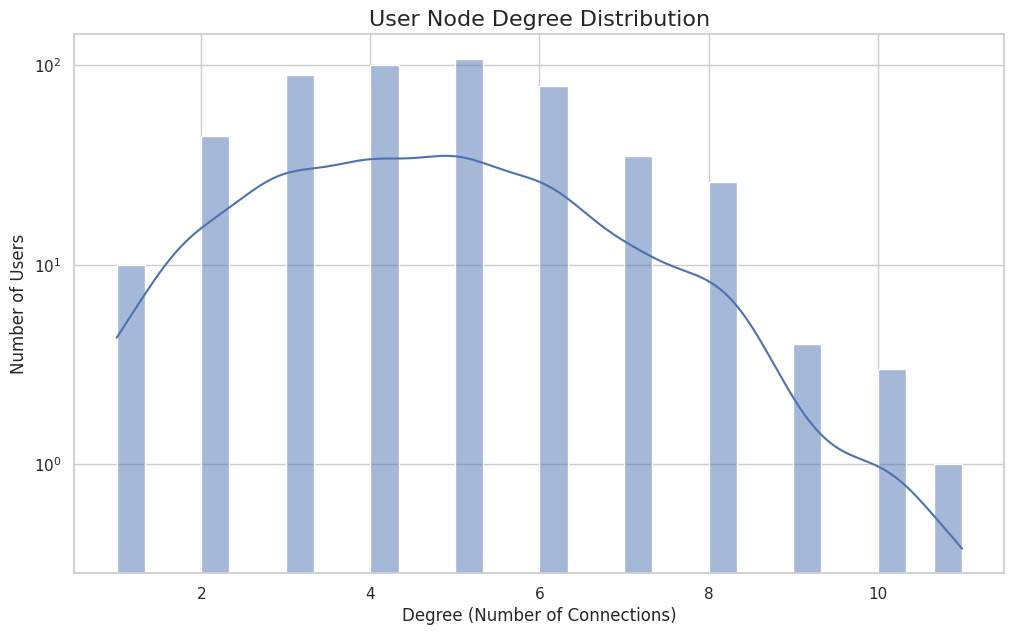

--- Top 5 Most Connected Users ---
   userId  degree
0      50      11
1     152      10
2     118      10
3      27      10
4     131       9


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mgclient

# --- Query Memgraph for user degrees ---
conn = mgclient.connect(host=MEMGRAPH_HOST, port=MEMGRAPH_PORT)
cursor = conn.cursor()
query_user_degrees = """
MATCH (u:User)-[r]->(c) 
WHERE type(r) IN ['HAS_SKILL', 'HAS_STRENGTH', 'SUBMITTED', 'VOTED_ON']
RETURN u.id AS userId, count(r) AS degree
ORDER BY degree DESC
"""
cursor.execute(query_user_degrees)
degree_df = pd.DataFrame(cursor.fetchall(), columns=["userId", "degree"])
conn.close()

# --- Plot the distribution ---
plt.figure(figsize=(12, 7))
ax = sns.histplot(data=degree_df, x='degree', bins=30, kde=True)
ax.set_title('User Node Degree Distribution', fontsize=16)
ax.set_xlabel('Degree (Number of Connections)', fontsize=12)
ax.set_ylabel('Number of Users', fontsize=12)
ax.set_yscale('log') # Use a log scale as degrees are often highly skewed
plt.show()

print("--- Top 5 Most Connected Users ---")
print(degree_df.head(5))

Running t-SNE... (this may take a moment)


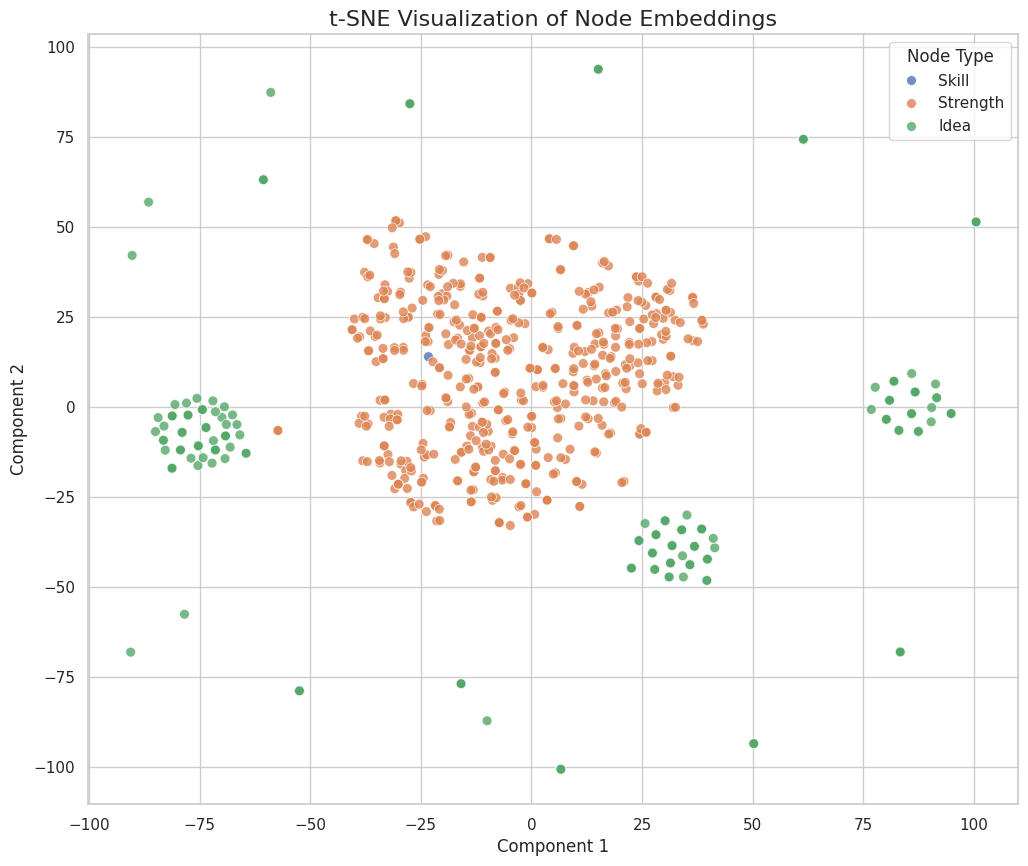

In [70]:
from sklearn.manifold import TSNE
import numpy as np

# --- Prepare data for t-SNE ---
# We'll visualize the content nodes to see if they form clusters
node_types_to_plot = ['Skill', 'Strength', 'Idea']
embeddings = []
labels = []

for node_type in node_types_to_plot:
    if node_type in graph_data.node_types:
        # Get embeddings and convert to numpy
        node_embeds = graph_data[node_type].x.cpu().numpy()
        embeddings.append(node_embeds)
        # Create a label for each node in this category
        labels.extend([node_type] * len(node_embeds))

if embeddings:
    embeddings_concat = np.concatenate(embeddings, axis=0)

    # --- Run t-SNE ---
    print("Running t-SNE... (this may take a moment)")
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
    embeddings_2d = tsne.fit_transform(embeddings_concat)
    
    # Create a DataFrame for plotting
    tsne_df = pd.DataFrame(embeddings_2d, columns=['Component 1', 'Component 2'])
    tsne_df['label'] = labels

    # --- Plot the results ---
    plt.figure(figsize=(12, 10))
    ax = sns.scatterplot(
        data=tsne_df,
        x='Component 1',
        y='Component 2',
        hue='label',
        palette='deep',
        alpha=0.8,
        s=50 # marker size
    )
    ax.set_title('t-SNE Visualization of Node Embeddings', fontsize=16)
    plt.legend(title='Node Type')
    plt.show()

else:
    print("No content nodes found to visualize.")

In [29]:
class HeteroGNN(nn.Module):
    def __init__(self, out_channels, metadata):
        super().__init__()
        # MODIFIED: Removed the restrictive 'if' condition.
        # This now creates a SAGEConv layer for EVERY edge type in the graph metadata,
        # making the model fully heterogeneous.
        self.conv = HeteroConv({
            edge_type: SAGEConv((-1, -1), out_channels) 
            for edge_type in metadata[1]
        }, aggr='sum')

    def forward(self, x_dict, edge_index_dict):
        # The forward pass automatically uses all defined convolution layers
        return self.conv(x_dict, edge_index_dict)

In [61]:
from torch_geometric.transforms import RandomLinkSplit

print("\n--- Initializing GNN Training for User-to-User Recommendations ---")

# MODIFIED: Define the edge type based on the data preparation step
edge_type_to_predict = ('User', 'SHARED_INTEREST', 'User')

# Check if there are enough edges to train on
if edge_type_to_predict not in graph_data.edge_types or graph_data[edge_type_to_predict].num_edges < 10: # Need a few edges
    print("⚠️ Not enough user-to-user edges found for training. GNN will not be trained.")
else:
    # --- NEW: Split edges to prevent data leakage ---
    # This transform splits the user-to-user edges into training (for message passing),
    # validation, and test sets (for supervision/evaluation).
    transform = RandomLinkSplit(
        is_undirected=True,
        num_val=0.1,  # 10% for validation
        num_test=0.1, # 10% for testing
        neg_sampling_ratio=1.0, # Sample 1 negative edge for each positive one
        edge_types=[edge_type_to_predict],
    )
    train_data, val_data, test_data = transform(graph_data)

    # --- Model Initialization ---
    gnn_model = LinkPredictor(out_channels=64, metadata=train_data.metadata())
    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001, weight_decay=5e-4)
    loss_fn = nn.BCEWithLogitsLoss()
    
    print(f"Model initialized. Training on {train_data[edge_type_to_predict].edge_label_index.size(1)} supervision edges.")
    print("Starting training loop...")

    # --- Training Loop ---
    for epoch in range(501):
        gnn_model.train()
        optimizer.zero_grad()
        
        # Get embeddings using ONLY the message-passing edges from train_data
        node_embeddings = gnn_model(train_data.x_dict, train_data.edge_index_dict)
        
        # Get the edges to train on (supervision edges)
        edge_label_index = train_data[edge_type_to_predict].edge_label_index
        edge_label = train_data[edge_type_to_predict].edge_label # Positive (1) and negative (0) labels

        # Decode on supervision edges
        preds = gnn_model.decode(node_embeddings, edge_label_index)
        
        # Compute loss and perform backpropagation
        loss = loss_fn(preds, edge_label)
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}")
            
    print("✅ GNN Training Complete.")


--- Initializing GNN Training for User-to-User Recommendations ---
Model initialized. Training on 79486 supervision edges.
Starting training loop...
Epoch 000, Loss: 0.7191
Epoch 010, Loss: 0.3074
Epoch 020, Loss: 0.1749
Epoch 030, Loss: 0.1516
Epoch 040, Loss: 0.1424
Epoch 050, Loss: 0.1377
Epoch 060, Loss: 0.1350
Epoch 070, Loss: 0.1331
Epoch 080, Loss: 0.1317
Epoch 090, Loss: 0.1304
Epoch 100, Loss: 0.1293
Epoch 110, Loss: 0.1284
Epoch 120, Loss: 0.1275
Epoch 130, Loss: 0.1266
Epoch 140, Loss: 0.1259
Epoch 150, Loss: 0.1252
Epoch 160, Loss: 0.1246
Epoch 170, Loss: 0.1240
Epoch 180, Loss: 0.1235
Epoch 190, Loss: 0.1230
Epoch 200, Loss: 0.1225
Epoch 210, Loss: 0.1221
Epoch 220, Loss: 0.1217
Epoch 230, Loss: 0.1214
Epoch 240, Loss: 0.1211
Epoch 250, Loss: 0.1208
Epoch 260, Loss: 0.1205
Epoch 270, Loss: 0.1202
Epoch 280, Loss: 0.1200
Epoch 290, Loss: 0.1198
Epoch 300, Loss: 0.1196
Epoch 310, Loss: 0.1194
Epoch 320, Loss: 0.1192
Epoch 330, Loss: 0.1190
Epoch 340, Loss: 0.1189
Epoch 350,

In [62]:
from sklearn.metrics import roc_auc_score

# --- Put model in evaluation mode ---
gnn_model.eval()

with torch.no_grad():
    # Get the final node embeddings using the graph structure from training
    final_embeddings = gnn_model(train_data.x_dict, train_data.edge_index_dict)
    
    # Get the edges and labels from the test set
    test_edge_index = test_data[edge_type_to_predict].edge_label_index
    test_edge_label = test_data[edge_type_to_predict].edge_label
    
    # Get predictions for the test edges
    test_preds = gnn_model.decode(final_embeddings, test_edge_index)
    
    # Convert raw scores (logits) to probabilities
    test_probs = test_preds.sigmoid()
    
    # --- Calculate AUC Score ---
    auc_score = roc_auc_score(test_edge_label.cpu().numpy(), test_probs.cpu().numpy())
    
    print(f"✅ Model evaluation complete.")
    print(f"Test AUC Score: {auc_score:.4f}")

✅ Model evaluation complete.
Test AUC Score: 0.9962


In [68]:
def compare_users(user1_id: int, user2_id: int):
    """
    Fetches profiles for two users from Memgraph and compares their data.
    """
    comparison = {}
    try:
        conn = mgclient.connect(host=MEMGRAPH_HOST, port=MEMGRAPH_PORT)
        cursor = conn.cursor()
        
        query = """
        MATCH (u:User)
        WHERE u.id IN [$user1_id, $user2_id]
        OPTIONAL MATCH (u)-[:HAS_SKILL]->(s:Skill)
        OPTIONAL MATCH (u)-[:HAS_STRENGTH]->(st:Strength)
        OPTIONAL MATCH (u)-[:VOTED_ON]->(i:Idea)
        RETURN u.id AS userId,
               COLLECT(DISTINCT s.name) AS skills,
               COLLECT(DISTINCT st.name) AS strengths,
               COLLECT(DISTINCT i.content) AS ideas
        """
        cursor.execute(query, {"user1_id": user1_id, "user2_id": user2_id})
        
        # Store data for both users
        user_data = {row[0]: {"skills": set(row[1]), "strengths": set(row[2]), "ideas": set(row[3])} for row in cursor.fetchall()}
        conn.close()

        # Perform the comparison using sets
        for category in ["skills", "strengths", "ideas"]:
            set1 = user_data.get(user1_id, {}).get(category, set())
            set2 = user_data.get(user2_id, {}).get(category, set())
            
            comparison[category] = {
                "shared": list(set1.intersection(set2)),
                f"user_{user1_id}_unique": list(set1.difference(set2)),
                f"user_{user2_id}_unique": list(set2.difference(set1))
            }
        
        return comparison

    except Exception as e:
        print(f"Could not compare users: {e}")
        return {"Error": "Could not connect to database for comparison."}

def get_recommendation_reasons(target_user_id: int, recommended_user_id: int):
    """
    Queries Memgraph to find shared items between two users to explain a recommendation.
    """
    try:
        conn = mgclient.connect(host=MEMGRAPH_HOST, port=MEMGRAPH_PORT)
        cursor = conn.cursor()
        
        query = """
        MATCH (u1:User {id: $target_id})
        MATCH (u2:User {id: $rec_id})
        // Find direct shared items
        OPTIONAL MATCH (u1)-[:HAS_SKILL]->(s:Skill)<-[:HAS_SKILL]-(u2)
        OPTIONAL MATCH (u1)-[:HAS_STRENGTH]->(st:Strength)<-[:HAS_STRENGTH]-(u2)
        OPTIONAL MATCH (u1)-[:VOTED_ON]->(i:Idea)<-[:VOTED_ON]-(u2)
        OPTIONAL MATCH (u1)-[:ENROLLED_IN]->(da:DailyActivity)<-[:ENROLLED_IN]-(u2)
        RETURN COLLECT(DISTINCT s.name) AS sharedSkills,
               COLLECT(DISTINCT st.name) AS sharedStrengths,
               COLLECT(DISTINCT i.id) AS sharedIdeas,
               COLLECT(DISTINCT da.name) AS sharedActivities
        """
        cursor.execute(query, {"target_id": target_user_id, "rec_id": recommended_user_id})
        result = cursor.fetchone()
        conn.close()

        reasons = {}
        if result:
            if result[0]: reasons['Shared Skills'] = result[0]
            if result[1]: reasons['Shared Strengths'] = result[1]
            if result[2]: reasons['Voted on Same Ideas'] = [str(idea) for idea in result[2]]
            if result[3]: reasons['Enrolled in Same Activities'] = result[3]

        # Fallback if no direct shared items are found
        if not reasons:
            reasons['Predicted Affinity'] = "High compatibility based on their network profiles and deeper interests."
            
        return reasons
    except Exception as e:
        print(f"Could not fetch reasons: {e}")
        return {"Error": "Could not connect to database to fetch reasons."}

def get_recommendations_for_user(user_id: int, top_k: int = 5):
    """
    Generates a ranked list of user recommendations with a detailed
    side-by-side comparison for each match.
    """
    print(f"\n--- Generating Top {top_k} Recommendations for User ID: {user_id} ---")
    
    gnn_model.eval()
    
    try:
        user_pyg_id = graph_data['User'].new_id_map[graph_data['User'].original_id_map == user_id].item()
    except (IndexError, ValueError):
        print(f"Error: User with ID {user_id} not found in the graph.")
        return

    # ... (The core logic to get top_k recommendations remains the same) ...
    with torch.no_grad():
        final_embeddings = gnn_model(train_data.x_dict, train_data.edge_index_dict)

    all_user_edges = graph_data[edge_type_to_predict].edge_index
    mask_to = all_user_edges[0] == user_pyg_id
    mask_from = all_user_edges[1] == user_pyg_id
    connected_pyg_ids = torch.cat([all_user_edges[1, mask_to], all_user_edges[0, mask_from]]).unique()

    all_pyg_ids = graph_data['User'].new_id_map
    candidate_mask = torch.ones_like(all_pyg_ids, dtype=torch.bool)
    candidate_mask[user_pyg_id] = False
    candidate_mask[connected_pyg_ids] = False
    candidate_pyg_ids = all_pyg_ids[candidate_mask]

    if len(candidate_pyg_ids) == 0:
        print("User is connected to everyone or no other users exist.")
        return
        
    source_nodes = torch.full_like(candidate_pyg_ids, fill_value=user_pyg_id)
    potential_edges = torch.stack([source_nodes, candidate_pyg_ids])
    
    with torch.no_grad():
        scores = gnn_model.decode(final_embeddings, potential_edges).sigmoid()

    k = min(top_k, len(candidate_pyg_ids))
    top_scores, top_indices = torch.topk(scores, k)
    recommended_pyg_ids = candidate_pyg_ids[top_indices]

    # --- FULLY UPDATED PRINTOUT SECTION ---
    for i, pyg_id in enumerate(recommended_pyg_ids):
        recommended_user_id = graph_data['User'].original_id_map[graph_data['User'].new_id_map == pyg_id].item()
        
        # Call the same comparison function as before
        comparison_details = compare_users(user_id, recommended_user_id)
        
        print(f"\n----------------------------------------------------")
        print(f"Recommendation #{i+1}: User {recommended_user_id} (Score: {round(top_scores[i].item(), 4)})")
        print(f"----------------------------------------------------")
        
        # Check if there is any data to display
        has_data = any(any(d.values()) for d in comparison_details.values())

        if not has_data:
            print("  Predicted Affinity: High compatibility based on their network profiles.")
            continue

        # Iterate through each category (skills, strengths, ideas)
        for category, data in comparison_details.items():
            # Check if there's anything to show for this category
            if not any(data.values()):
                continue

            print(f"\n  -- Comparison for {category.capitalize()} --")
            if data['shared']:
                print(f"    Shared: {data['shared']}")
            
            user1_key = f"user_{user_id}_unique"
            if data[user1_key]:
                print(f"    Target User ({user_id}) Unique: {data[user1_key]}")

            user2_key = f"user_{recommended_user_id}_unique"
            if data[user2_key]:
                print(f"    Recommended User ({recommended_user_id}) Unique: {data[user2_key]}")

example_user_id = 2
get_recommendations_for_user(user_id=example_user_id, top_k=5)


--- Generating Top 5 Recommendations for User ID: 2 ---

----------------------------------------------------
Recommendation #1: User 451 (Score: 0.6847)
----------------------------------------------------

  -- Comparison for Ideas --
    Shared: ['A virtual reality training platform for high-risk professions like mining and construction.']
    Target User (2) Unique: ['A platform that connects local farmers directly with restaurants to reduce food waste.']

----------------------------------------------------
Recommendation #2: User 41 (Score: 0.6766)
----------------------------------------------------

  -- Comparison for Strengths --
    Recommended User (41) Unique: ['Designer, blown glass/stained glass', 'Surveyor, minerals']

  -- Comparison for Ideas --
    Shared: ['A virtual reality training platform for high-risk professions like mining and construction.', 'A platform that connects local farmers directly with restaurants to reduce food waste.']

--------------------------

In [17]:
torch.save(gnn_model.state_dict(), 'user_link_predictor.pth')

In [69]:
print(f"Model initialized. Training on {train_data[edge_type_to_predict].edge_label_index.size(1)} supervision edges.")

Model initialized. Training on 79486 supervision edges.
